In [35]:
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import numpy as np
import warnings
import math
import re

tqdm.pandas()
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

%run ../src/utils.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
train.shape

(814262, 11)

In [37]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
test.shape

(202937, 11)

In [38]:
data = pd.concat([train, test], axis=0)
data.shape

(1017199, 11)

# Distance Evaluation
Euclidian, Minkowski, Haversine distances.

In [39]:
def euclidian_distance(x_one, y_one, x_two, y_two):
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

def minkowski_distance(x_one, y_one, x_two, y_two):
    return abs(x_one-x_two) + abs(y_one-y_two)

data['euclidian_distance'] = np.sqrt(np.power(data.x_entry.values-data.x_exit.values, 2)+np.power(data.y_entry.values-data.y_exit.values, 2))

data['minkowski_distance'] = np.abs(data.x_entry.values-data.x_exit.values) + np.abs(data.y_entry.values-data.y_exit.values)

In [40]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

data['harvesine_distance'] = [haversine(x1, y1, x2, y2) for x1, y1, x2, y2 in zip(data.x_entry, data.y_entry,
                                                                                data.x_exit, data.y_exit)]

In [262]:
data = data[data.euclidian_distance!=0]
data.shape

(491966, 47)

### Distances from Center Borders
Euclidian distance from point to city center borders.

In [331]:
from shapely.geometry import Point, Polygon, LineString

center['left_border']  = LineString([(center['x_min'], center['y_min']), (center['x_min'], center['y_max'])])
center['right_border'] = LineString([(center['x_max'], center['y_min']), (center['x_max'], center['y_max'])])

center['lower_border']  = LineString([(center['x_min'], center['y_min']), (center['x_max'], center['y_min'])])
center['upper_border']  = LineString([(center['x_min'], center['y_max']), (center['x_max'], center['y_max'])])

center['left_border'].distance(Point(center['x_max'], center['y_min']))

20000.0

In [332]:
def distance_to_border(x, y, direction):
    return center[direction + '_border'].distance(Point(x, y))

data['distance_left_border'] = [distance_to_border(x, y, direction='left') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_right_border'] = [distance_to_border(x, y, direction='right') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_lower_border'] = [distance_to_border(x, y, direction='lower') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_upper_border'] = [distance_to_border(x, y, direction='upper') for x, y in zip(data.x_entry, data.y_entry)]

## Target feature

In [333]:
def is_inside_city(x, y):
    if (3750901.5068 <= x <= 3770901.5068) and (-19268905.6133 <= y <= -19208905.6133):
        return 1
    else:
        return 0

data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

# Grid Sections
We'll start off dividing our trajectory map in grids meant to cover any posible entry point in our data

In [334]:
xmin, ymin, xmax, ymax = data.x_entry.min(), data.y_entry.min(), data.x_entry.max(), data.y_entry.max()

xmax-xmin, ymax-ymin

(36068.62821192667, 340258.3224131949)

In [43]:
from shapely.geometry import Polygon

# 10x3 grids, given the height/width ratio is predominantly vertical
y_count = 10
x_count = 3

grid_h = (ymax-ymin)/y_count
grid_w = (xmax-xmin)/x_count

grids = {'{}_{}'.format(i+1,j+1): Polygon([
            (xmin + grid_w*i, ymin + grid_h*j), (xmin + grid_w*i, ymin + grid_h*(j+1)),
            (xmin + grid_w*(i+1), ymin + grid_h*(j+1)), (xmin + grid_w*(i+1), ymin + grid_h*j)]) \
         for i in range(0, x_count) \
         for j in range(0, y_count)}

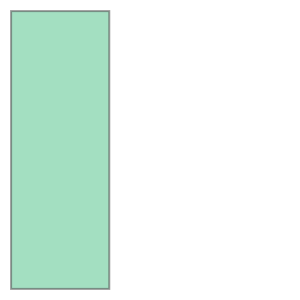

In [46]:
grids['1_1']

In [47]:
grid_cols = ['entry_grid_' + grid for grid in grids.keys()]
data = data.reindex(columns=data.columns.tolist() + grid_cols)

In [48]:
for (_, grid), col in zip(grids.items(), grid_cols):
    data[col] = data.apply(lambda row: grid.contains(Point(row['x_entry'], row['y_entry'])), axis=1)

In [49]:
data[grid_cols] = data[grid_cols].astype(int)

In [175]:
for col in grid_cols:
    data.loc[data[col] == 1, 'neighbors'] = data[col].sum()

data.head(5)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,entry_grid_3_2,entry_grid_3_3,entry_grid_3_4,entry_grid_3_5,entry_grid_3_6,entry_grid_3_7,entry_grid_3_8,entry_grid_3_9,entry_grid_3_10,neighbors
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,0,0,0,0,0,0,0,0,5729.0
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,0,0,0,0,0,0,0,0,11925.0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,0,0,0,0,0,0,0,0,31417.0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,0,0,0,0,0,0,0,0,31417.0
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,0,0,0,0,0,0,0,0,0,31417.0


# Clustering
Based on new grid input data, we'll explore clustering results for our train set.

In [335]:
from sklearn.cluster import KMeans

cluster_cols = ['x_entry', 'y_entry', 'neighbors', 'is_inside_city_entry',
                'distance_left_border', 'distance_right_border', 'distance_lower_border', 'distance_upper_border'] + grid_cols

train_data = data[data.hash.isin(train.hash.unique())]

kmeans = KMeans(n_clusters=4, random_state=20)
kmeans.fit(train_data[grid_cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=20, tol=0.0001, verbose=0)

In [336]:
kmeans.labels_

array([0, 0, 3, ..., 3, 3, 0])

In [337]:
len(kmeans.labels_), train_data.shape[0]

(380248, 380248)

In [338]:
train_data['cluster'] = kmeans.labels_

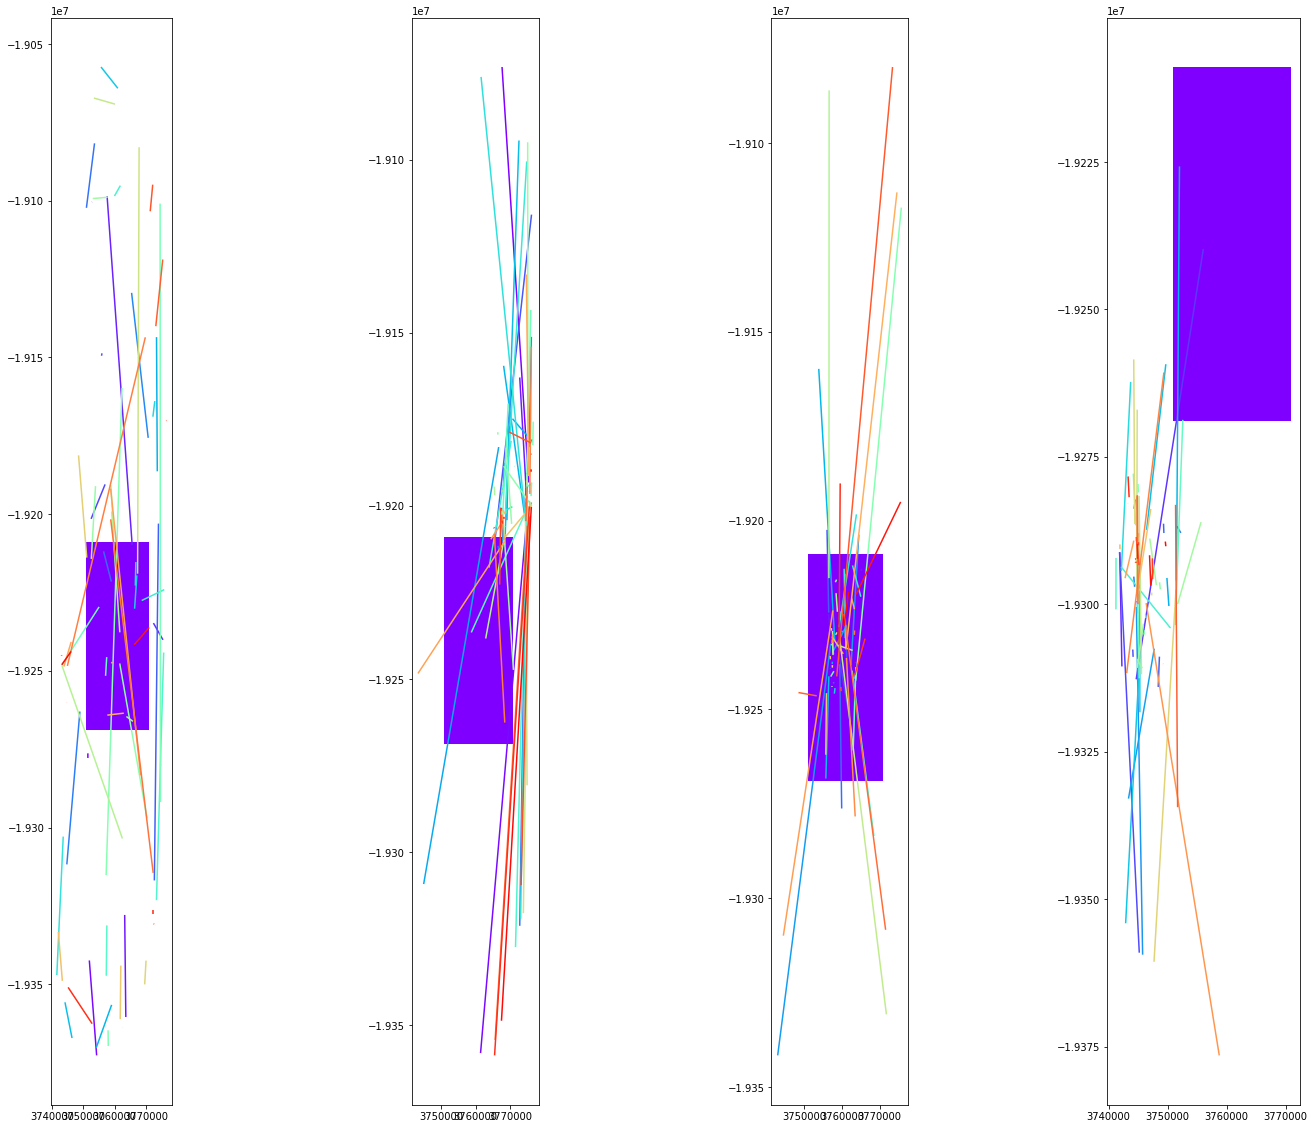

In [339]:
train_data['time_entry'] = pd.to_timedelta(train_data.time_entry)
train_data['time_exit'] = pd.to_timedelta(train_data.time_exit)

trajectory_count = 600
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(25, 20))

cluster1 = train_data[train_data.cluster == 0]
cluster2 = train_data[train_data.cluster == 1]
cluster3 = train_data[train_data.cluster == 2]
cluster4 = train_data[train_data.cluster == 3]

geoplot(cluster1.tail(trajectory_count), ax=ax1)
geoplot(cluster2.tail(trajectory_count), ax=ax2)
geoplot(cluster3.tail(trajectory_count), ax=ax3)
geoplot(cluster4.tail(trajectory_count), ax=ax4)

# Cluster Analysis

In [340]:
(cluster1.euclidian_distance.mean(),
cluster2.euclidian_distance.mean(),
cluster3.euclidian_distance.mean(),
cluster4.euclidian_distance.mean())

(31417.065143082735, 23799.67959434604, 16220.56529613586, 19533.01220520981)

In [341]:
arr = lambda: np.empty([4]).tolist()

longest, shortest = arr(), arr()
short_staying_in, short_staying_out = arr(), arr()
short_leaving_center, short_entering_center = arr(), arr()
long_staying_in, long_staying_out = arr(), arr()
long_leaving_center, long_entering_center = arr(), arr()

for i, c in enumerate([cluster1, cluster2, cluster3, cluster4]):
    longest[i] = c.sort_values('euclidian_distance', ascending=False).head(c.shape[0]//2).copy()
    shortest[i] = c.sort_values('euclidian_distance', ascending=True).head(c.shape[0]//2).copy()

    short_staying_in[i] = shortest[i][(shortest[i].is_inside_city_entry == 1) & (shortest[i].is_inside_city_exit == 1)]
    short_staying_out[i] = shortest[i][(shortest[i].is_inside_city_entry == 0) & (shortest[i].is_inside_city_exit == 0)]
    short_leaving_center[i] = shortest[i][(shortest[i].is_inside_city_entry == 1) & (shortest[i].is_inside_city_exit == 0)]
    short_entering_center[i] = shortest[i][(shortest[i].is_inside_city_entry == 0) & (shortest[i].is_inside_city_exit == 1)]

    long_staying_in[i] = longest[i][(longest[i].is_inside_city_entry == 1) & (longest[i].is_inside_city_exit == 1)]
    long_staying_out[i] = longest[i][(longest[i].is_inside_city_entry == 0) & (longest[i].is_inside_city_exit == 0)]
    long_leaving_center[i] = longest[i][(longest[i].is_inside_city_entry == 1) & (longest[i].is_inside_city_exit == 0)]
    long_entering_center[i] = longest[i][(longest[i].is_inside_city_entry == 0) & (longest[i].is_inside_city_exit == 1)]

In [347]:
def cluster_plot(i, short_qtt=500, long_qtt=500):
    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(ncols=4, nrows=2, figsize=(30, 40))

    ax_font = 20
    fig.suptitle('Cluster {}'.format(i+1), fontsize=25)

    # Shortest
    shortest_len = len(shortest[i])
    short_probs = [
        100 * len(short_staying_in[i]) / shortest_len,
        100 * len(short_staying_out[i]) / shortest_len,
        100 * len(short_leaving_center[i]) / shortest_len,
        100 * len(short_entering_center[i]) / shortest_len
    ]
    
    ax1.set_title('Staying in center: {:.3f}%'.format(short_probs[0]), fontsize=ax_font)
    if short_probs[0] > 0.0:
        geoplot(c1_short_staying_in.head(short_qtt), ax=ax1)
    
    ax2.set_title('Staying out of center: {:.3f}%'.format(short_probs[1]), fontsize=ax_font)
    if short_probs[1] > 0.0:
        geoplot(c1_short_staying_out.head(short_qtt), ax=ax2)
    
    ax3.set_title('Entering: {:.3f}%'.format(short_probs[2]), fontsize=ax_font)
    if short_probs[2] > 0.0:
        geoplot(c1_short_entering_center.head(short_qtt), ax=ax3)
    
    ax4.set_title('Leaving: {:.3f}%'.format(short_probs[3]), fontsize=ax_font)
    if short_probs[3] > 0.0:
        geoplot(c1_short_leaving_center.head(short_qtt), ax=ax4)

    # Longest
    longest_len = len(longest[i])
    long_probs = [
        100 * len(long_staying_in[i]) / longest_len,
        100 * len(long_staying_out[i]) / longest_len,
        100 * len(long_leaving_center[i]) / longest_len,
        100 * len(long_entering_center[i]) / longest_len
    ]
    
    ax5.set_title('Staying in center: {:.3f}%'.format(long_probs[0]), fontsize=ax_font)
    if long_probs[0] > 0.0:
        geoplot(c1_short_staying_in.head(long_qtt), ax=ax5)
    
    ax6.set_title('Staying out of center: {:.3f}%'.format(long_probs[1]), fontsize=ax_font)
    if long_probs[1] > 0.0:
        geoplot(c1_short_staying_out.head(long_qtt), ax=ax6)
    
    ax7.set_title('Entering: {:.3f}%'.format(long_probs[2]), fontsize=ax_font)
    if long_probs[2] > 0.0:
        geoplot(c1_short_entering_center.head(long_qtt), ax=ax7)
    
    ax8.set_title('Leaving: {:.3f}%'.format(long_probs[3]), fontsize=ax_font)
    if long_probs[3] > 0.0:
        geoplot(c1_short_leaving_center.head(long_qtt), ax=ax8)

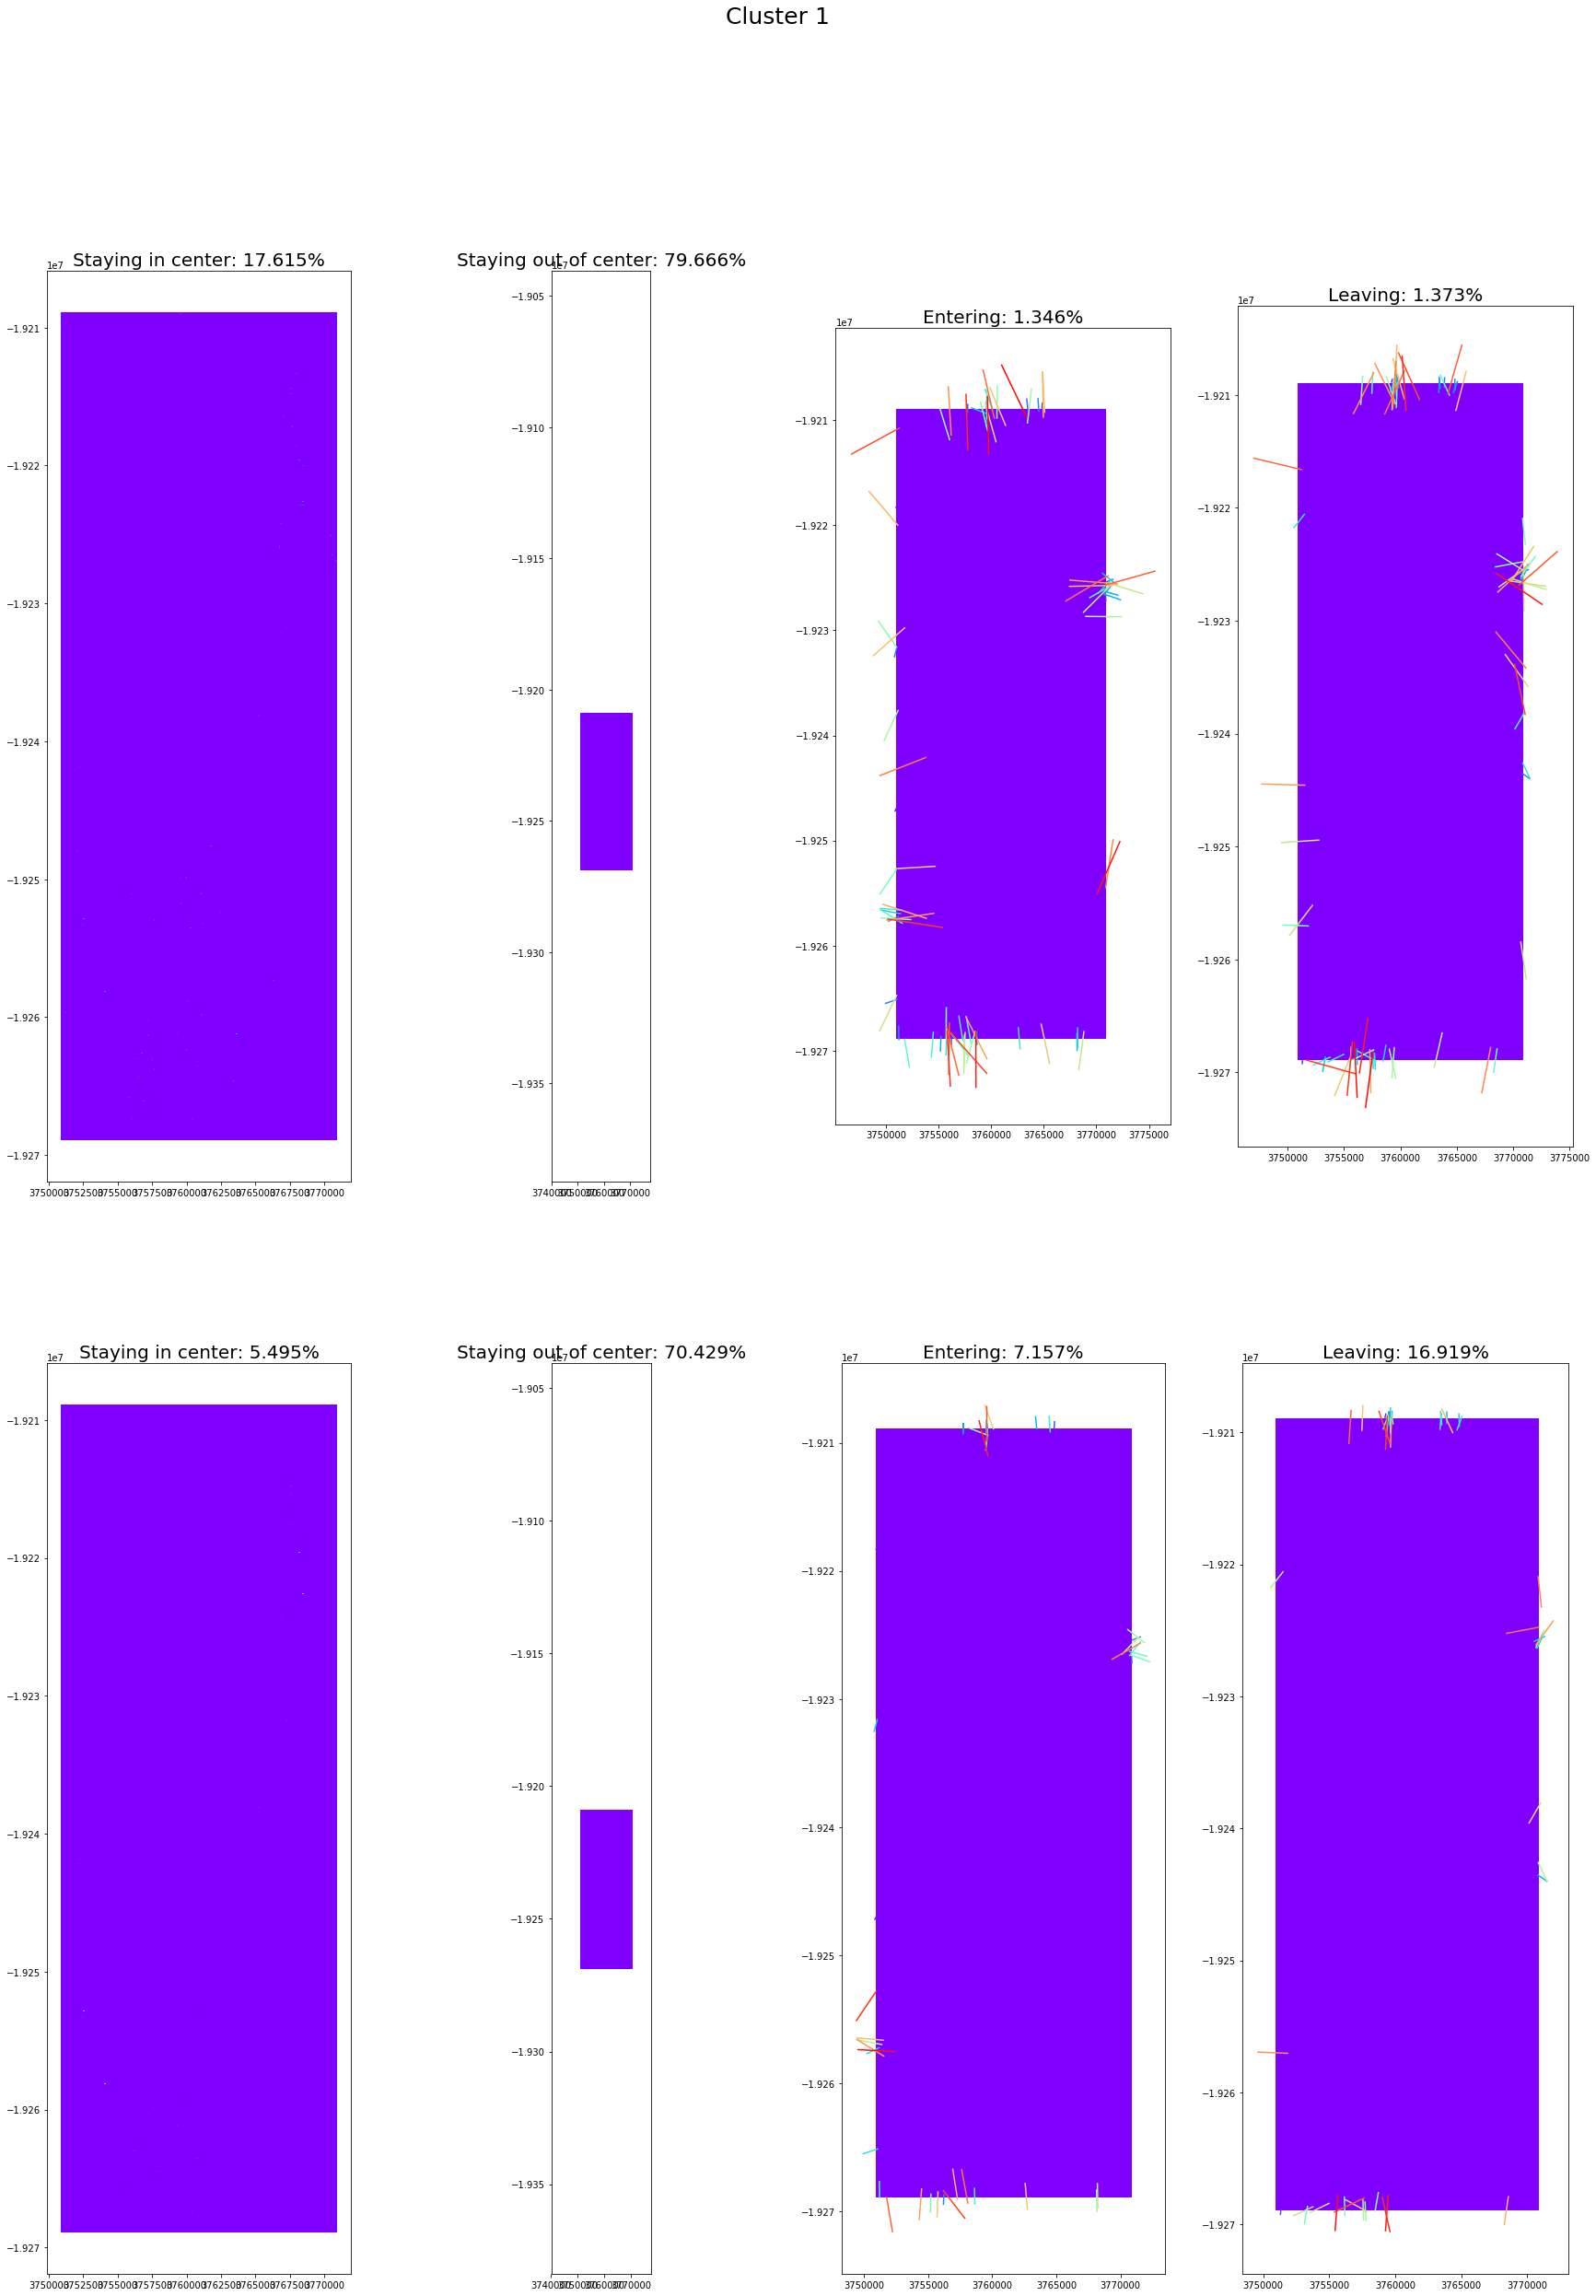

In [348]:
cluster_plot(0, short_qtt=800, long_qtt=400)

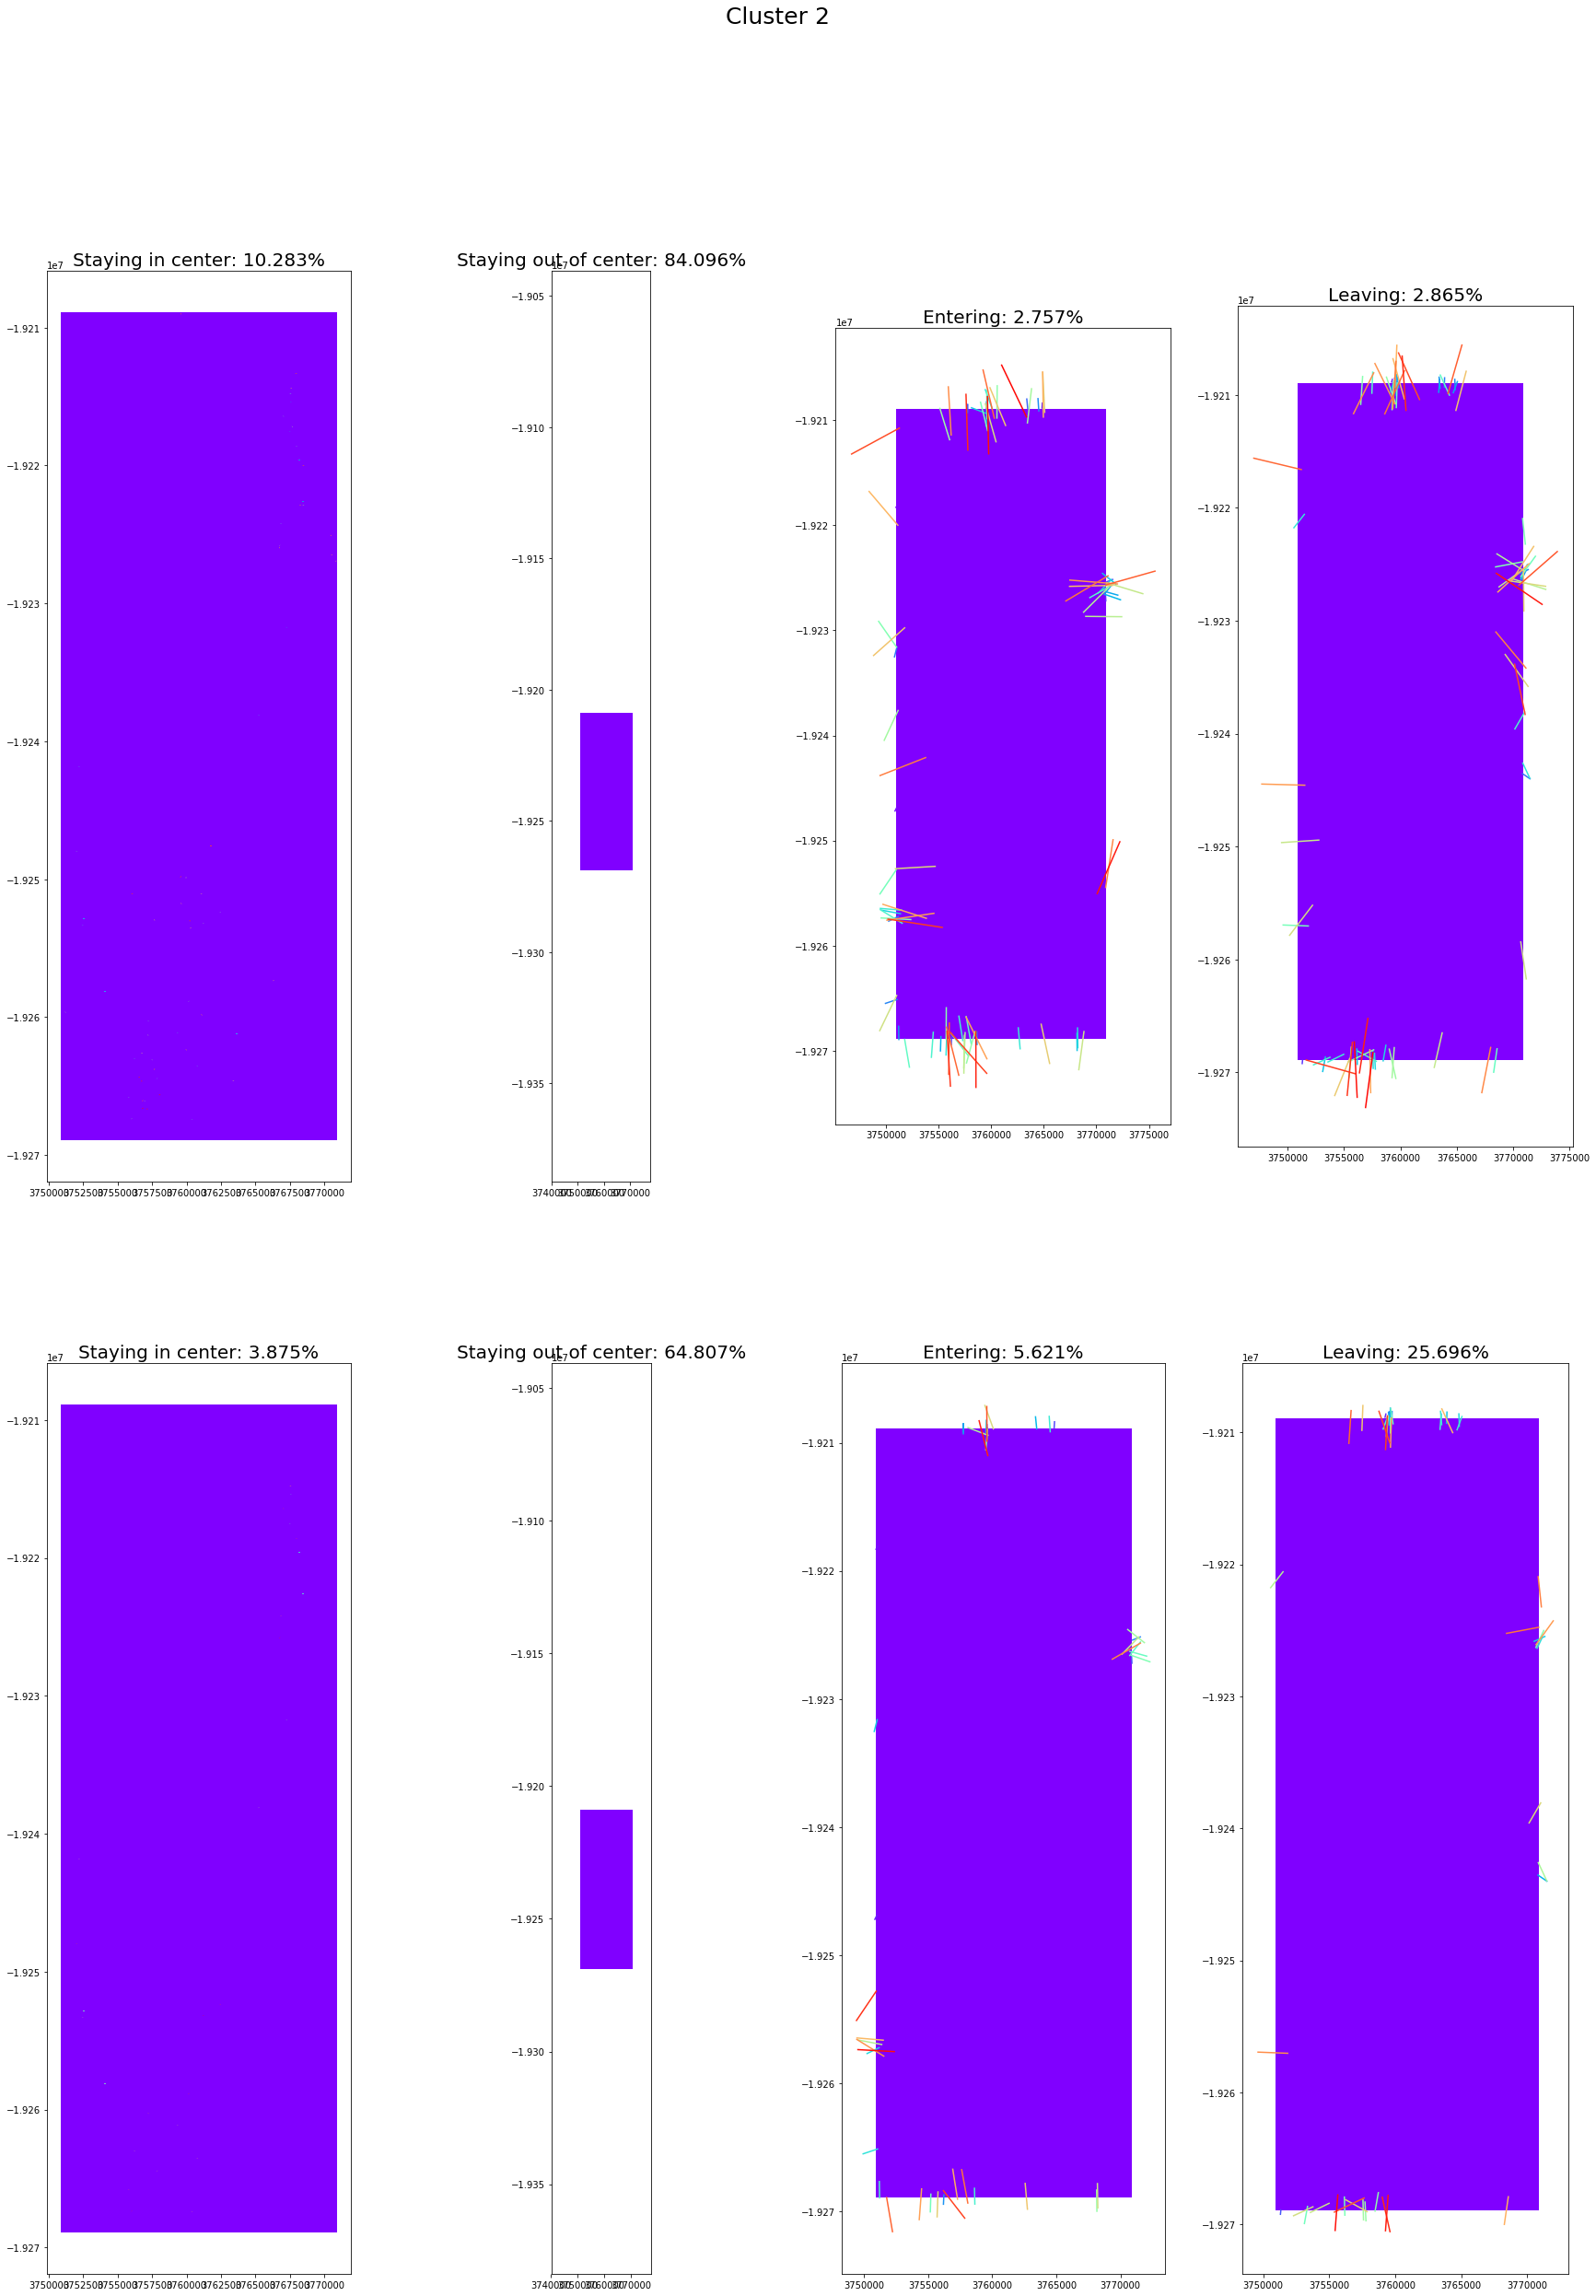

In [349]:
cluster_plot(1, short_qtt=800, long_qtt=400)

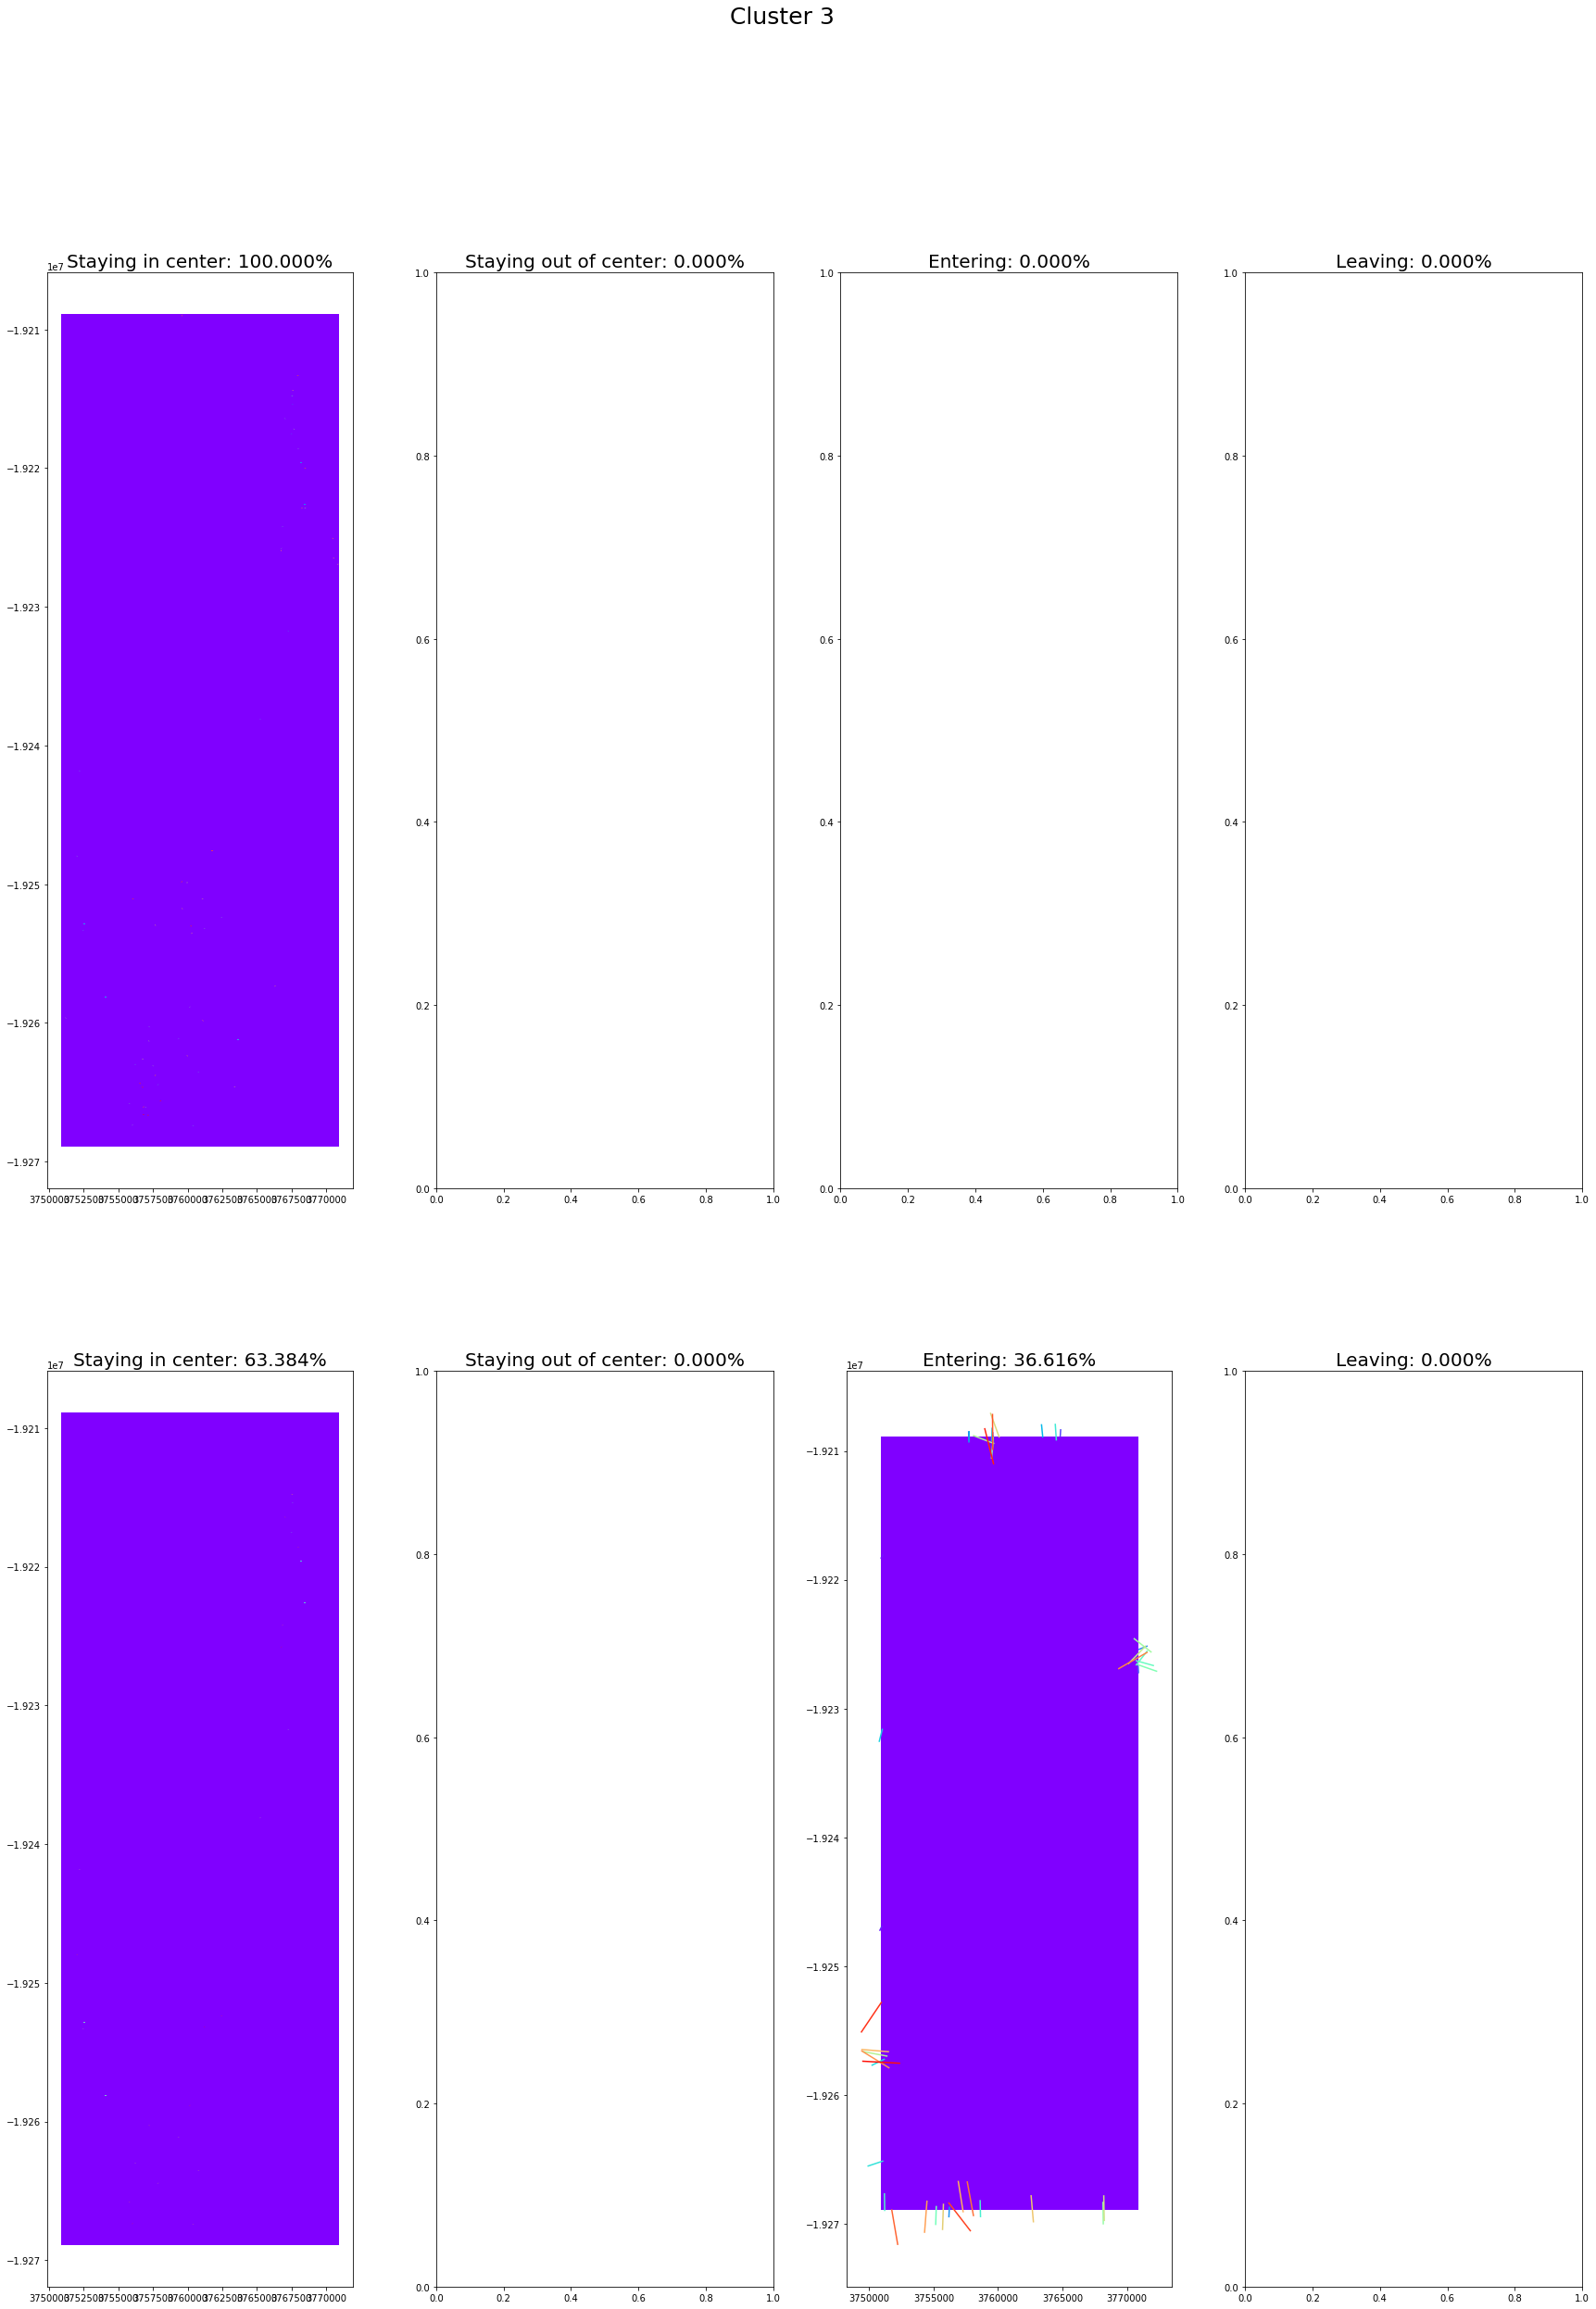

In [350]:
cluster_plot(2, short_qtt=800, long_qtt=400)

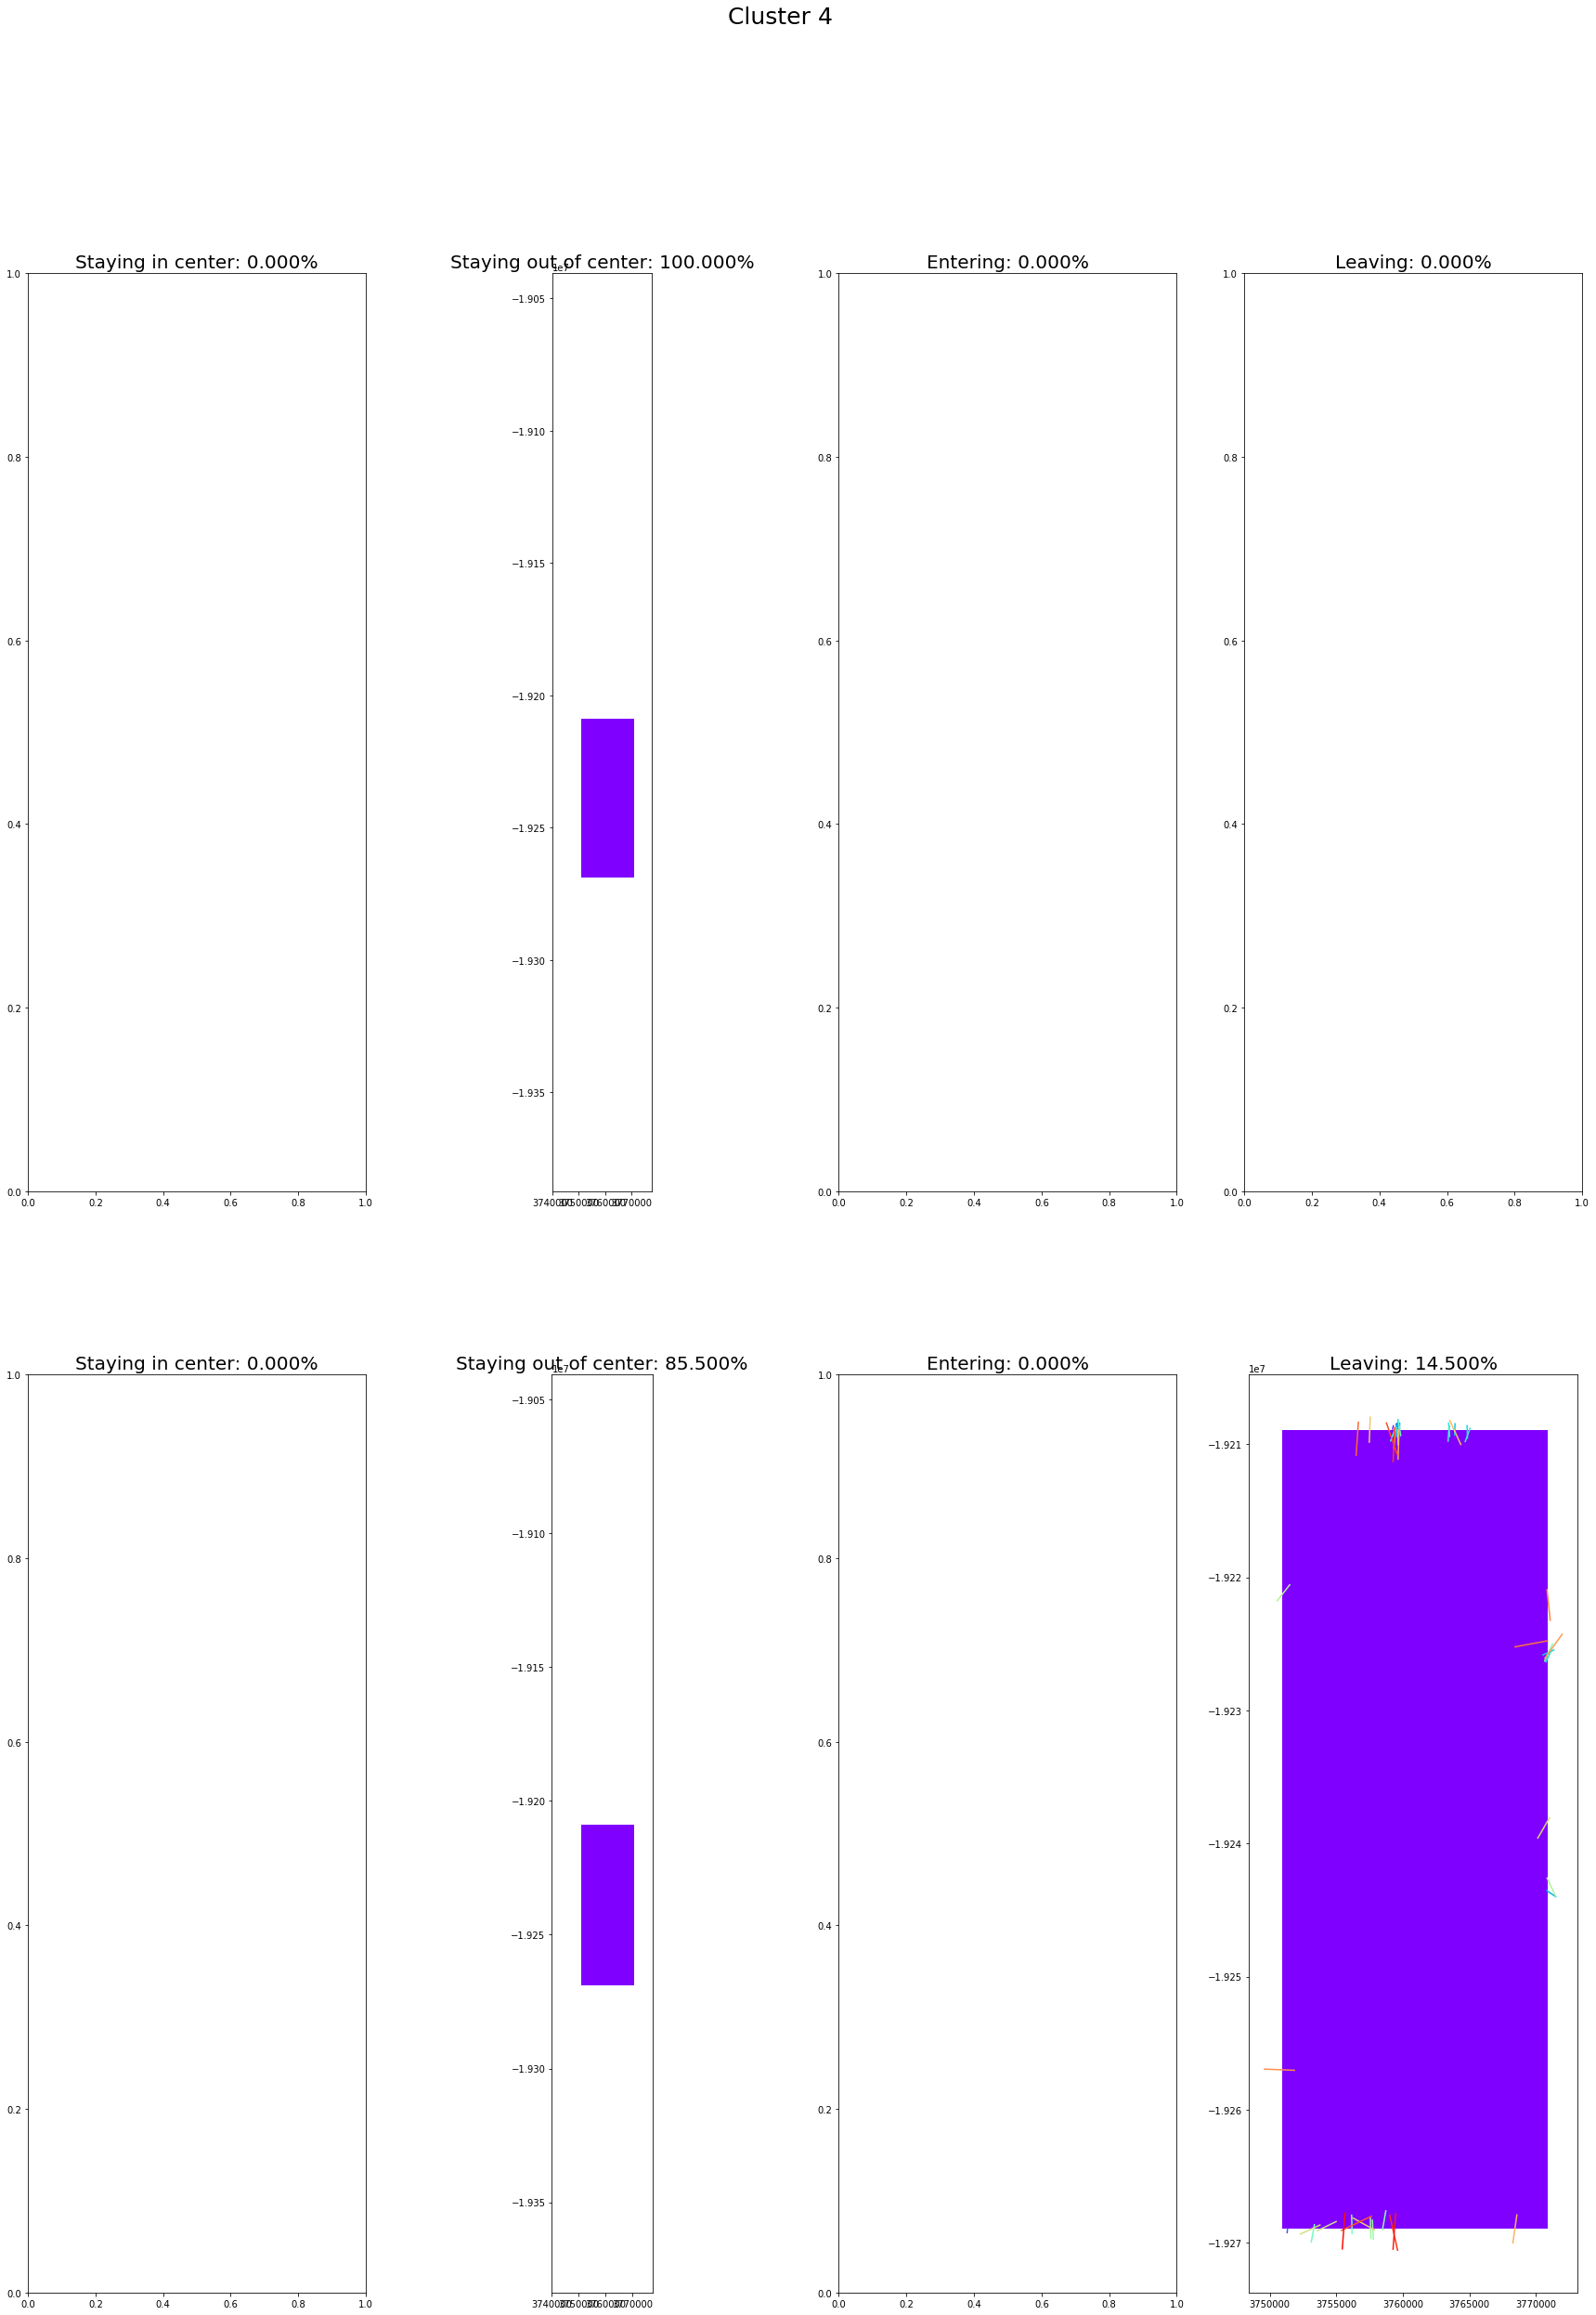

In [351]:
cluster_plot(3, short_qtt=800, long_qtt=400)

## Feature Engineering

In [ ]:
data['last_x_entry'] = data.groupby('hash').x_exit.shift(1)
data['last_y_entry'] = data.groupby('hash').y_exit.shift(1)

angle_cols = [
    'cc_middle_angle', 'cc_xmin_ymin_angle', 'cc_xmax_ymin_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymax_angle'
]

data = data.reindex(columns=data.columns.tolist() + angle_cols)

data = data.progress_apply(entry_to_center_angles, axis=1)

data = data.drop(columns=['last_x_entry', 'last_y_entry'])

data.head(4)

In [ ]:
data[angle_cols] = data[angle_cols] * 180.0 / np.pi
data.head(4)

In [ ]:
# transforming time variable to timedelta format in pandas
# return np.nan when entry/exit times = np.NaN, due to Zero Imputations.
data['minute_entry'] = data.time_entry.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[1]))
data['minute_exit'] = data.time_exit.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[0]))
data['hour_exit'] = data.time_exit.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

In [ ]:
x_center = 3750901.5068 + ((3770901.5068-3750901.5068)/2)
y_center = -19268905.6133 + ((-19208905.6133+19268905.6133)/2)

In [ ]:
center = {
    'x_min': 3750901.5068, 'y_min': -19268905.6133,
    'x_max': 3770901.5068, 'y_max': -19208905.6133
}

In [ ]:
def quadrant(x, y, which):
    if which == 'third':
        if center['x_min'] <= x <= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
        
    elif which == 'first':
        if center['x_min'] <= x <= x_center and center['y_max'] >= y >= y_center:
            return 1
        else:
            return 0
        
    elif which == 'fourth':
        if center['x_max'] >= x >= x_center and center['y_min'] >= y >= y_center:
            return 1
        else:
            return 0
    elif which == 'second':
        if center['x_max'] >= x >= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
    else:
        return 0
        

data['first_quadrant_entry'] = [quadrant(x, y, which='first') for x, y in zip(data.x_entry, data.y_entry)]
data['third_quadrant_entry'] = [quadrant(x, y, which='third') for x, y in zip(data.x_entry, data.y_entry)]
data['fourth_quadrant_entry'] = [quadrant(x, y, which='fourth') for x, y in zip(data.x_entry, data.y_entry)]
data['second_quadrant_entry'] = [quadrant(x, y, which='second') for x, y in zip(data.x_entry, data.y_entry)]

In [ ]:
data['center_permanency'] = data.progress_apply(center_permanency, axis=1)

In [ ]:
# time passed between blind spots

data['time_delta_blind'] = (data.time_entry - data.time_exit.shift(1)) / np.timedelta64(1, 'm')

In [ ]:
# time passed between blind spots

data['x_delta_blind'] = data.x_entry - data.x_exit.shift(1)
data['y_delta_blind'] = data.y_entry - data.y_exit.shift(1)

data['distance_blind'] = ((data.x_delta_blind**2) + (data.y_delta_blind)**2)**(1/2)

data.loc[data.time_delta_blind < 0, 'distance_blind'] = 0

data.loc[data.time_delta_blind < 0, 'x_delta_blind'] = 0
data.loc[data.time_delta_blind < 0, 'y_delta_blind'] = 0
data.loc[data.time_delta_blind < 0, 'time_delta_blind'] = 0

data.head(4)

In [ ]:
data['trajectory_number'] = data.trajectory_id.progress_apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

data.loc[data.trajectory_number==0, 'distance_blind'] = 0
data.loc[data.trajectory_number==0, 'time_delta_blind'] = 0

In [ ]:
data['distance_cc_entry'] = np.sqrt(((data.x_entry.values-x_center)**2) + ((data.y_entry.values-y_center)**2))
data['distance_cc_exit'] = np.sqrt(((data.x_exit.values-x_center)**2) + ((data.y_exit.values-y_center)**2))

data['diff_cc_exit_entry'] = data.distance_cc_exit - data.distance_cc_entry

In [ ]:
data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

data['deltat_min'] = (data.time_exit - data.time_entry) / np.timedelta64(1, 'm')

In [ ]:
data['x_diff_entry'] = data.x_entry.values-x_center
data['x_diff_exit'] = data.x_exit.values-x_center

data['y_diff_entry'] = data.y_entry.values-y_center
data['y_diff_exit'] = data.y_exit.values-y_center

In [ ]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [ ]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

In [ ]:
#data['velocity'] = data['euclidian_distance'] / data['deltat_min']
#data['acceleration'] = data['haversineersinelidian_distance'] / data['deltat_min']

In [ ]:
def has_crossed_city(row):
    
    is_inside_city_entry = is_inside_city(row['x_entry'], row['y_entry'])
    is_inside_city_exit  = is_inside_city(row['x_exit'], row['y_exit'])
    
    line = LineString([(row['x_entry'], row['y_entry']), (row['x_exit'], row['y_exit'])])
    
    if not line.intersects(center_polygon):
        return 0
    
    if line.length == 0:
        # avoids divisions by 0 in 'point' trajectories
        return 0
    
    
    if line.intersects(center_polygon) and is_inside_city_entry == 0 and is_inside_city_exit == 1:
        return 1
    
    return 0

#data['has_crossed_city'] = data.progress_apply(has_crossed_city, axis=1)

For full trigonometric observation, let's keep track of angles in degrees.

### Aggregating features

In [113]:
data.columns.tolist()

['hash',
 'trajectory_id',
 'time_entry',
 'time_exit',
 'vmax',
 'vmin',
 'vmean',
 'x_entry',
 'y_entry',
 'x_exit',
 'y_exit',
 'euclidian_distance',
 'minkowski_distance',
 'harvesine_distance',
 'minute_entry',
 'minute_exit',
 'hour_entry',
 'hour_exit',
 'is_inside_city_entry',
 'is_inside_city_exit',
 'first_quadrant_entry',
 'third_quadrant_entry',
 'fourth_quadrant_entry',
 'second_quadrant_entry',
 'center_permanency',
 'time_delta_blind',
 'x_delta_blind',
 'y_delta_blind',
 'distance_blind',
 'trajectory_number',
 'distance_cc_entry',
 'distance_cc_exit',
 'diff_cc_exit_entry',
 'deltat_min',
 'x_diff_entry',
 'x_diff_exit',
 'y_diff_entry',
 'y_diff_exit',
 'direction_entry',
 'direction_exit',
 'distance_left_border',
 'distance_right_border',
 'distance_lower_border',
 'distance_upper_border',
 'cc_middle_angle',
 'cc_xmin_ymin_angle',
 'cc_xmax_ymin_angle',
 'cc_xmin_ymax_angle',
 'cc_xmax_ymax_angle']

In [283]:
window_reference = 5

cols_to_agg = ['vmax', 'vmin', 'vmean', 'x_entry', 'y_entry', 'minute_entry', 'hour_entry',
               'first_quadrant_entry', 'third_quadrant_entry', 'fourth_quadrant_entry', 'second_quadrant_entry',
               'trajectory_number', 'distance_cc_entry', 'deltat_min', 'x_diff_entry', 'y_diff_entry', 'direction_entry',
               'distance_left_border', 'distance_right_border', 'distance_lower_border', 'distance_upper_border'] + angle_cols

agg_features = (data.groupby(['hash', 'time_entry', 'trajectory_id'])[cols_to_agg]
                .mean()
                .shift(1)
                .rolling(window_reference, min_periods=1)
                .agg(['mean', 'max', 'std', 'min', 'sum']))

agg_features.columns = ["_".join(x) for x in agg_features.columns.ravel()]
data = data.merge(agg_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
data.head(4)

KeyError: "Columns not found: 'cc_xmin_ymin_angle', 'cc_xmax_ymax_angle', 'cc_middle_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymin_angle'"

# Sequence Data

In [ ]:
window_reference = 5

grouped = data.groupby(['hash']).tail(window_reference)
grouped['sequence'] = np.ones(grouped.shape[0])
df = grouped.groupby(by=['hash','time_entry', 'trajectory_id']).sum().groupby(level=[0]).cumsum().reset_index()[['trajectory_id', 'sequence']]
df.columns = ['trajectory_id', 'trajectory_sequence']
grouped = grouped.merge(df, on='trajectory_id', how='left')

In [ ]:
hash_count_trajectories = grouped.groupby(['hash']).trajectory_id.count().reset_index()
hash_count_trajectories.columns = ['hash', 'count_trajectories']

grouped = grouped.merge(hash_count_trajectories, on='hash', how='left')
grouped.head(4)

In [ ]:
ref = window_reference
for i in range(1, window_reference):
    grouped.loc[grouped.count_trajectories==i, 'trajectory_sequence'] += ref-1
    ref -= 1
    
grouped.head(4)

In [ ]:
grouped = grouped.drop('sequence', axis=1)
#grouped['traje']

In [ ]:
data_sequence = grouped.groupby(['hash', 'trajectory_sequence']).mean().unstack()
data_sequence.shape

In [ ]:
data_sequence.columns = ['_'.join([x[0], str(int(x[1]))]) for x in data_sequence.columns.ravel()]
data_sequence.head(3)

In [ ]:
data_sequence = data_sequence.reset_index()

In [ ]:
data_sequence.shape

In [ ]:
data_train = data_sequence[data_sequence['hour_exit_'+str(window_reference)]==15]
data_train.shape

In [ ]:
hashs_train = list(train.hash.unique())
hashs_test = list(test.hash.unique())

data_train = data_train[data_train.hash.isin(hashs_train)]
data_train.shape

In [ ]:
drop_cols = ['x_exit', 'y_exit', 'euclidian_distance', 'minkowski_distance',
            'harvesine_distance', 'minute_exit', 'is_inside_city_exit', 'center_permanency',
            'distance_cc_exit', 'diff_cc_exit_entry', 'x_diff_exit', 'y_diff_exit', 'direction_exit',
            'has_crossed_city', 'velocity']

drop_cols = [col+'_'+str(window_reference) for col in drop_cols]
drop_cols += ['hash']

features = list(set(data_train.columns) - set(drop_cols))
target   = ['is_inside_city_exit_'+str(window_reference)]

In [ ]:
from sklearn.model_selection import train_test_split


dt_train, dt_test = train_test_split(data_train, test_size=0.2, random_state=20)
dt_train.shape, dt_test.shape

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

clf = LGBMClassifier(n_estimators=150, max_features=0.5, seed=20)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

In [ ]:
# Score 0.7413765697027499 | 0.89307 - n_estimators=150, max_features=0.5

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(40).plot(kind='barh')

In [ ]:
data_test = data_sequence[data_sequence.hash.isin(hashs_test)]
#data_test = test[test['x_exit_'+str(window_reference)].isnull()]

In [ ]:
data_test.shape

In [ ]:
ids = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
ids = ids[ids.x_exit.isnull()]

In [ ]:
data_test = data_test.merge(ids[['hash', 'trajectory_id']], on='hash')

In [ ]:
clf.fit(data_train[features], data_train[target])
yhat = clf.predict(data_test[features])

In [ ]:
pd.Series(yhat).value_counts()

In [ ]:
data_test.head(4)

In [ ]:
submission = pd.DataFrame(list(zip(data_test['trajectory_id'], yhat)), columns=['id', 'target'])

In [306]:
submission.to_csv('../data/submission38_julio.csv', index=False)